# Performance Analysis
In this Python notebook the algorithms will be assessed on their performance, more specifically the execution time of the algorithms will be analyzed.

In [1]:
# Libraries used in this python notebook
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from tqdm import tqdm
import time

In [2]:
# These are the algorithms, which we are assessing
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for _ in range(n):
        goal_amnt = sum([int(random.random() < p_i) for p_i in p_is])
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

from poibin.poibin import PoiBin

def fft(p_is):
    return PoiBin(p_is).get_pmf_xi()

In [3]:
# Determine the maximum number of Possession xG values per team and match
xg_df = pd.read_pickle('possession_xGs.pkl')
xg_counts = xg_df.groupby('match_id').apply(lambda df: df.groupby('team_id')['team_id'].count()).sort_values()
max_n = xg_counts.max()
print(f'Maximum number of Possession xG per team and match is {max_n}')

Maximum number of Possession xG per team and match is 43


As a rule of thumb to get a representative value for the execution time we repeat the algorithm with the same input such that the average aggregate running time is 1 second.

In [4]:
REPEAT = 100
SIMULATION_RUNS = 10000
xg_counts = xg_counts.to_frame()
xg_counts.columns = ['xg_count']
xg_counts = xg_counts.reset_index()
for count in tqdm(np.sort(xg_counts['xg_count'].unique())):
    i_counts = xg_counts[xg_counts['xg_count'] == count]
    match_id = i_counts.sample()['match_id'].iat[0]
    team_id = i_counts[i_counts['match_id'] == match_id].sample()['team_id'].iat[0]
    p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()
    results = []
    execution_times_det = []
    execution_times_sim = []
    for _ in range(REPEAT):
        start = time.time() 
        results.append(dp(p_is))
        results.append(fft(p_is))
        stop = time.time()
        execution_times_det.append((stop - start)/2)
        start = time.time() 
        results.append(simulation(p_is, SIMULATION_RUNS))
        stop = time.time()
        execution_times_sim.append(stop - start)
print(f'Sum of runs for all algorithms is {len(results)}')
del results
print(f'Median Execution time of the deterministic algorithms is {np.median(execution_times_det)}s')
print(f'Average Execution time of the simulations is {np.average(execution_times_sim)}s')
n_reiterate_det = int(1/np.median(execution_times_det))+1
n_reiterate_sim = int(1/np.average(execution_times_sim))+1
print(f'Recommended number of reiterations for the determinitstic algorithms is {n_reiterate_det}')
print(f'Recommended number of reiterations for the simulation is {n_reiterate_sim}')

100%|██████████| 37/37 [03:47<00:00,  6.14s/it]

Sum of runs for all algorithms is 300
Median Execution time of the deterministic algorithms is 0.0004773736000061035s
Average Execution time of the simulations is 0.1284603762626648s
Recommended number of reiterations for the determinitstic algorithms is 2095
Recommended number of reiterations for the simulation is 8


Now we will assess the algorithms on our match data by measuring their execution time with the recommended amount of reiterations.

In [5]:
execution_times_dp = []
execution_times_fft = []
execution_times_sim = []
for count in tqdm(np.sort(xg_counts['xg_count'].unique())):
    i_counts = xg_counts[xg_counts['xg_count'] == count]
    match_id = i_counts.sample()['match_id'].iat[0]
    team_id = i_counts[i_counts['match_id'] == match_id].sample()['team_id'].iat[0]
    p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()
    results = []
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    execution_times_sim_agg = []
    for _ in range(n_reiterate_det):
        start = time.perf_counter_ns()
        results.append(dp(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(fft(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
    for _ in range(n_reiterate_sim):
        start = time.perf_counter_ns()
        results.append(simulation(p_is, SIMULATION_RUNS)) 
        stop = time.perf_counter_ns()
        execution_times_sim_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))
    execution_times_sim.append((count, execution_times_sim_agg))

100%|██████████| 37/37 [00:50<00:00,  1.36s/it]


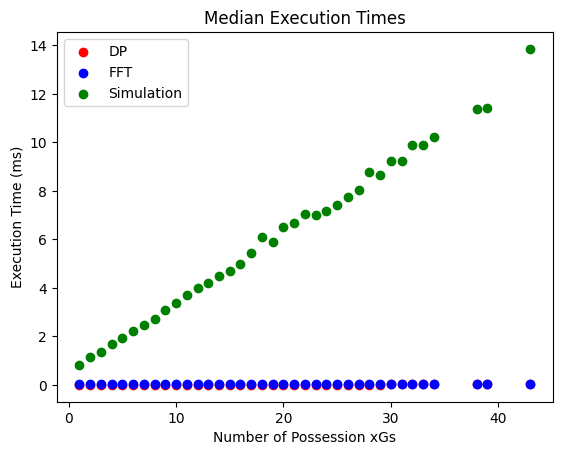

In [6]:
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1])/10e6 for t in execution_times_dp], c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1])/10e6 for t in execution_times_fft], c='blue', label='FFT')
plt.scatter([t[0] for t in execution_times_sim], [np.median(t[1])/10e6 for t in execution_times_sim], c='green', label='Simulation')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.show()

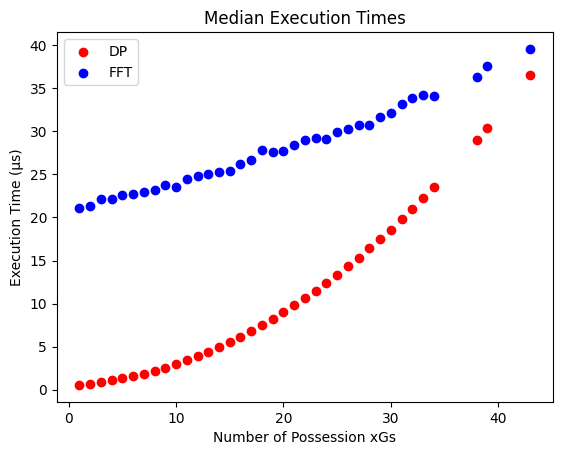

In [7]:
plt.clf()
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1])/10e3 for t in execution_times_dp], c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1])/10e3 for t in execution_times_fft], c='blue', label='FFT')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

In [8]:
print([t[0] for t in execution_times_dp])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 43]


The execution times for the DP and FFT algorithm seem to intersect at around 40 $p_i$'s. To analyze this further we can sample from the empirical distribution from the Possession xGs up to 100 $p_i$'s.

In [9]:
# TODO: Sample from Possession xG to further Analyze this and then put a linear regression to find out the constants
execution_times_dp = []
execution_times_fft = []
N = 100
for count in tqdm(range(1, N+1)):
    p_is = xg_df.sample(count, replace=True)['possession_xg'].to_list()
    results = []
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    for _ in range(n_reiterate_det):
        start = time.perf_counter_ns()
        results.append(dp(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(fft(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))
# Transform the execution times from nanoseconds to microseconds
execution_times_dp = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp]
execution_times_fft = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft]

100%|██████████| 100/100 [04:12<00:00,  2.52s/it]


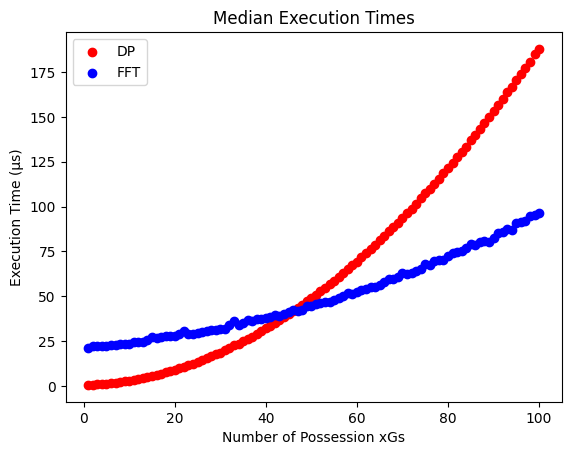

In [10]:
plt.clf()
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1]) for t in execution_times_dp], c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1]) for t in execution_times_fft], c='blue', label='FFT')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

The DP algorithm has asymptotic runtime $\mathcal{\Theta}(n^2)$, while the FFT algorithm has the asymptotic runtime $\mathcal{\Theta}(n \cdot \log(n))$. Let's now fit the following functions to the execution times:
- DP: $an^2 + bn + c$
- FFT: $dn \cdot \log(n) + en + f$
Where $n$ is the number of $p_i$'s which the algorithms get as input.

In [11]:
# Fit to the DP execution times
dp_x = []
for n, times in execution_times_dp:
    dp_x.append([n] * len(times))
dp_x = np.array(sum(dp_x, []))
dp_y = np.array(sum([t[1] for t in execution_times_dp], []))
dp_poly = PolynomialFeatures(degree=2, include_bias=False)
dp_poly_features = dp_poly.fit_transform(dp_x.reshape(-1, 1))
dp_poly_reg_model = LinearRegression()
dp_poly_reg_model.fit(dp_poly_features, dp_y)
dp_y_predicted = dp_poly_reg_model.predict(dp_poly.fit_transform(np.arange(1, N+1).reshape(-1, 1)))
print(f'DP Regression Model coefficients: {dp_poly_reg_model.coef_}, y_Intercept: {dp_poly_reg_model.intercept_}')
print(f'Root Mean Squared Error to the Medians of execution times: {mean_squared_error([np.median(t[1]) for t in execution_times_dp], dp_y_predicted, squared=False)}')

DP Regression Model coefficients: [0.08968454 0.01832154], y_Intercept: 0.6412958090909768
Root Mean Squared Error to the Medians of execution times: 2.5124206713567445


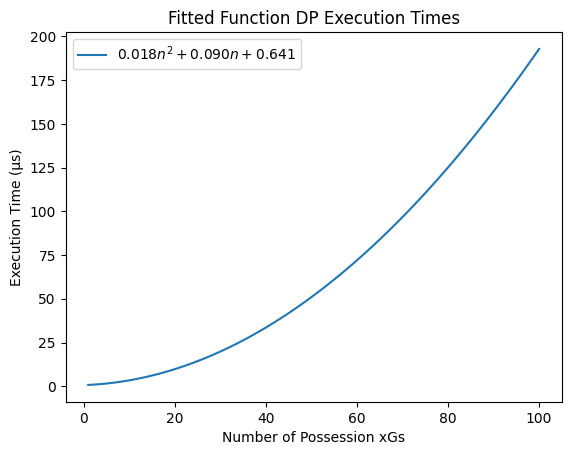

In [12]:
# Plot the fitted DP function
plt.clf()
b, a = dp_poly_reg_model.coef_
plt.plot(range(1, N+1), dp_y_predicted, label=f'${a:.3f}n^2 + {b:.3f}n + {dp_poly_reg_model.intercept_:.3f}$')
plt.title('Fitted Function DP Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

In [13]:
# Fit to the FFT execution times
fft_x = []
for n, times in execution_times_fft:
    fft_x.append([n] * len(times))
fft_x = np.array(sum(fft_x, [])).reshape(-1, 1)
n_log_n = fft_x * np.log(fft_x)
fft_transformed_x = np.hstack((fft_x, n_log_n))
fft_y = np.array(sum([t[1] for t in execution_times_fft], []))
fft_reg_model = LinearRegression()
fft_reg_model.fit(fft_transformed_x, fft_y)
predict_x = np.arange(1, N+1).reshape(-1, 1)
n_log_n = predict_x * np.log(predict_x)
predict_x_transformed = np.hstack((predict_x, n_log_n))
fft_y_predicted = fft_reg_model.predict(predict_x_transformed)
print(f'DP Regression Model coefficients: {fft_reg_model.coef_}, y_Intercept: {fft_reg_model.intercept_}')
print(f'Root Mean Squared Error to the Medians of execution times: {mean_squared_error([np.median(t[1]) for t in execution_times_fft], fft_y_predicted, squared=False)}')

DP Regression Model coefficients: [-1.46050747  0.46182355], y_Intercept: 30.669100938867132
Root Mean Squared Error to the Medians of execution times: 3.234379990713924


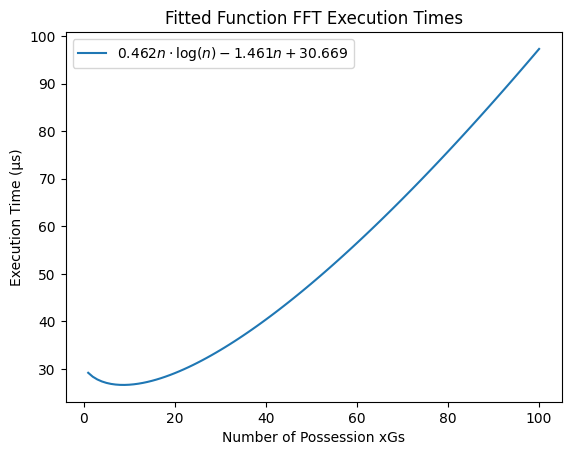

In [14]:
# Plot the fitted FFT function
plt.clf()
d, c = fft_reg_model.coef_
plt.plot(range(1, N+1), fft_y_predicted, label=f'${c:.3f}n \cdot \log(n) {d:.3f}n + {fft_reg_model.intercept_:.3f}$')
plt.title('Fitted Function FFT Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

The curves intersect at n = 47.257414553048186


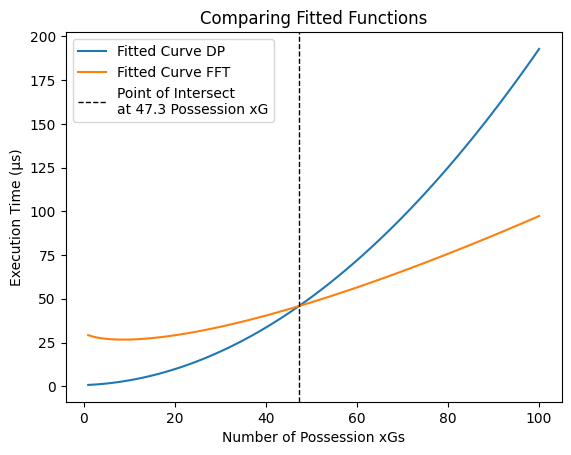

In [15]:
# Compare the two fitted functions
plt.clf()
plt.plot(range(1, N+1), dp_y_predicted, label='Fitted Curve DP')
plt.plot(range(1, N+1), fft_y_predicted, label='Fitted Curve FFT')
# Find the intersection point
dp_func = lambda n: a*n**2 + b*n + dp_poly_reg_model.intercept_
fft_func = lambda n: c * n * np.log(n) + d * n + fft_reg_model.intercept_
diff_func = lambda n: dp_func(n) - fft_func(n)
# Our inital guesses are 35 and 45, as we can estimate that from interpreting the graph
intersect = fsolve(diff_func, np.array([35, 45]))[0]
print(f'The curves intersect at n = {intersect}')
plt.axvline(intersect, color='black', linestyle='--', linewidth=1, label=f'Point of Intersect\nat {intersect:.1f} Possession xG')
plt.title('Comparing Fitted Functions')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

Eventually the hypothesis that sorting the input array in ascending/descending order changes the running time is also tested.

In [23]:
execution_times_dp = []
execution_times_fft = []
execution_times_dp_asc = []
execution_times_fft_asc = []
execution_times_dp_desc = []
execution_times_fft_desc = []
N = 60
for count in tqdm(range(1, N+1)):
    p_is = xg_df.sample(count, replace=True)['possession_xg'].to_list()
    p_is_asc = sorted(p_is, reverse=False)
    p_is_desc = sorted(p_is, reverse=True)
    results = []
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    execution_times_dp_asc_agg = []
    execution_times_fft_asc_agg = []
    execution_times_dp_desc_agg = []
    execution_times_fft_desc_agg = []
    for _ in range(n_reiterate_det):
        # DP
        start = time.perf_counter_ns()
        results.append(dp(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(dp(p_is_asc)) 
        stop = time.perf_counter_ns()
        execution_times_dp_asc_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(dp(p_is_desc)) 
        stop = time.perf_counter_ns()
        execution_times_dp_desc_agg.append(stop - start)
        # FFT
        start = time.perf_counter_ns()
        results.append(fft(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(fft(p_is_asc)) 
        stop = time.perf_counter_ns()
        execution_times_fft_asc_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(fft(p_is_desc)) 
        stop = time.perf_counter_ns()
        execution_times_fft_desc_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))
    execution_times_dp_asc.append((count, execution_times_dp_asc_agg))
    execution_times_fft_asc.append((count, execution_times_fft_asc_agg))
    execution_times_dp_desc.append((count, execution_times_dp_desc_agg))
    execution_times_fft_desc.append((count, execution_times_fft_desc_agg))
# Transform the execution times from nanoseconds to microseconds
execution_times_dp = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp]
execution_times_fft = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft]
execution_times_dp_asc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp_asc]
execution_times_fft_asc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft_asc]
execution_times_dp_desc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp_desc]
execution_times_fft_desc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft_desc]

100%|██████████| 60/60 [03:47<00:00,  3.80s/it]


In [17]:
# Let us have a look at the maximum absolute difference of the median execution times of the ordered values to the normal input values
max_abs_diff_dp_asc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_dp]) - np.array([np.median(t[1]) for t in execution_times_dp_asc])))
max_abs_diff_dp_desc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_dp]) - np.array([np.median(t[1]) for t in execution_times_dp_desc])))
max_abs_diff_fft_asc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_fft]) - np.array([np.median(t[1]) for t in execution_times_fft_asc])))
max_abs_diff_fft_desc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_fft]) - np.array([np.median(t[1]) for t in execution_times_fft_desc])))
print(f'Maximum absolute difference between medians of normal input vs. ascending sorted input DP: {max_abs_diff_dp_asc}')
print(f'Maximum absolute difference between medians of normal input vs. descending sorted input DP: {max_abs_diff_dp_desc}')
print(f'Maximum absolute difference between medians of normal input vs. ascending sorted input FFT: {max_abs_diff_fft_asc}')
print(f'Maximum absolute difference between medians of normal input vs. descending sorted input FFT: {max_abs_diff_fft_desc}')

Maximum absolute difference between medians of normal input vs. ascending sorted input DP: 0.6152000000000015
Maximum absolute difference between medians of normal input vs. descending sorted input DP: 0.6417000000000002
Maximum absolute difference between medians of normal input vs. ascending sorted input FFT: 4.7575999999999965
Maximum absolute difference between medians of normal input vs. descending sorted input FFT: 5.266500000000001


It seems like sorting the input has no considerable effect on execution time for the DP algorithm. For the FFT algorithm there seems to be a more considerable effect. Let us plot these execution times.

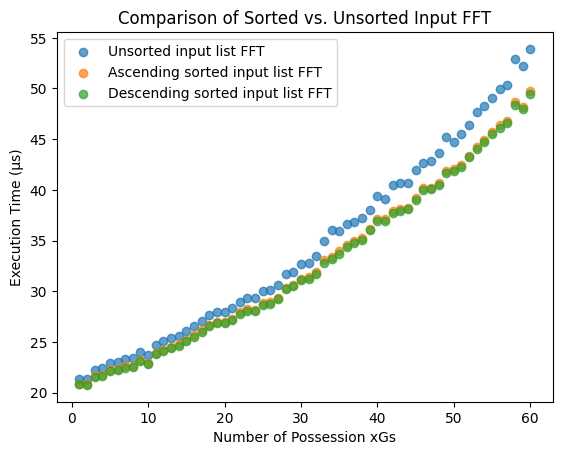

In [24]:
plt.clf()
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft], alpha=0.7, label='Unsorted input list FFT')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft_asc], alpha=0.7, label='Ascending sorted input list FFT')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft_desc], alpha=0.7, label='Descending sorted input list FFT')
plt.title('Comparison of Sorted vs. Unsorted Input FFT')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

For the notion of completeness let's also compare the unsorted vs. sorted input graphically for the DP algorithm.

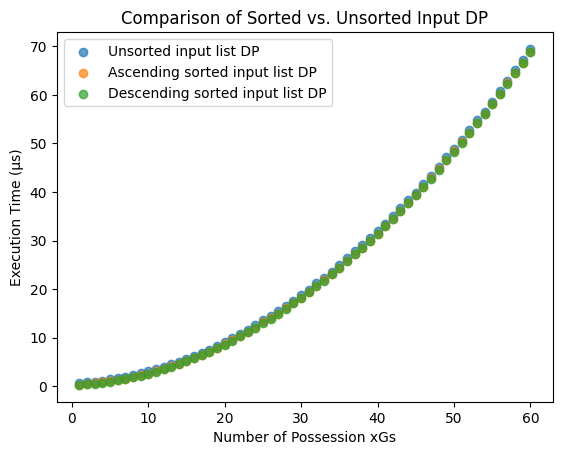

In [19]:
plt.clf()
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp], alpha=0.7, label='Unsorted input list DP')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp_asc], alpha=0.7, label='Ascending sorted input list DP')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp_desc], alpha=0.7, label='Descending sorted input list DP')
plt.title('Comparison of Sorted vs. Unsorted Input DP')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

Both deterministic algorithms seem to profit off of sorting the input list. While the FFT algorithm seems to have a better speedup, the speedup provided by sorting is neglible for the DP algorithm. Of the two sorted directions there seems to be a slight bias of speedup in the descending sorted order for both algorithms.

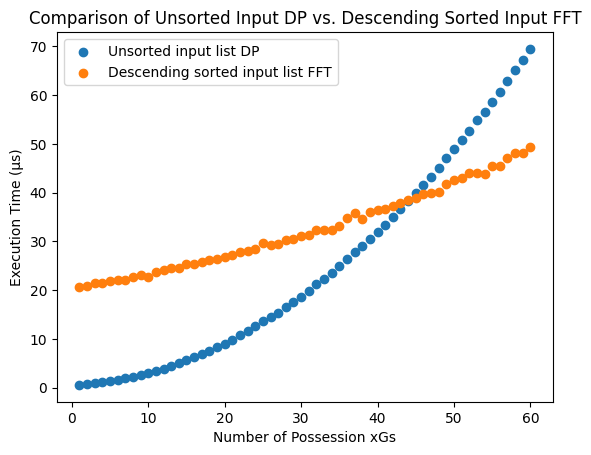

In [20]:
# Compare the descending ordered input list FFT algorithm to the unsorted DP algorithm
plt.clf()
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp], label='Unsorted input list DP')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft_desc], label='Descending sorted input list FFT')
plt.title('Comparison of Unsorted Input DP vs. Descending Sorted Input FFT')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

In [21]:
# TODO: Plot execution times for sorting first and then executing the algorithm